# Imports, spark init, dataset read

In [98]:
from pyspark.sql import SparkSession

import sys
import numpy as np
from pyspark.sql.functions import col, explode, array, lit, round, when, mean as _mean
import plotly.graph_objects as go
import pyspark.sql.functions as sql_func
import pyspark.sql.functions as F
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, IntegerType, FloatType, BooleanType
from functools import reduce
import matplotlib.pyplot as plt
from pyspark.sql import DataFrame
from pyspark.sql.functions import col
from pyspark.ml.regression import GeneralizedLinearRegression, LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, FeatureHasher
seed = 777

In [99]:
def init_spark():
    spark = SparkSession \
        .builder \
        .master('local[*]')\
        .appName("Python Spark SQL basic example") \
        .config("spark.driver.memory", "15g")\
        .getOrCreate()
    return spark

We do not need 'Country' column, since it only has one value, it is clear we work in the scope of USA, 
'id' provides no relevant information either, so can be dropped

We also add a year column to easily distinguish on when the specific accdent occured

In [100]:
def read_dataset(filename):
    spark = init_spark()
    total_accidents_data = spark.read.csv(filename, header=True, mode="DROPMALFORMED", encoding="ISO-8859-1", inferSchema=True)
    # dropped meaningless and 1 class only columns
    final_result = total_accidents_data.drop('Country').drop('id')\
        .withColumn('start_year', sql_func.date_format(total_accidents_data.Start_Time, 'y'))
      
    return final_result

In [101]:
root_accidents_data = read_dataset('data/US_Accidents_Dec20.csv')
root_accidents_data.printSchema()

root
 |-- Source: string (nullable = true)
 |-- TMC: double (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: string (nullable = true)
 |-- End_Time: string (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Number: double (nullable = true)
 |-- Street: string (nullable = true)
 |-- Side: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: string (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): doub

To reflect on the above output:
TMC - is the accident code assigned by the authorities full list can be found here:
https://wiki.openstreetmap.org/wiki/TMC/Event_Code_List

In [102]:
# Total dataset count is:
root_accidents_data.count()

4232541

# Data analysis and cleanup, imbalance treatment, feature engineering

### Data source and meta

In [103]:
# we will use these functions to display a pie chart of a column
def display_piechart_of_column(accidents_dataframe: DataFrame, column_name: str):
    counted_accidents = accidents_dataframe.withColumn(column_name, col(column_name).cast('string'))\
        .groupBy(column_name).count()
        
    counted_accidents = counted_accidents.collect()
    labels = [label[column_name] for label in counted_accidents]
    counts = [label['count'] for label in counted_accidents]
    count_sum = reduce(lambda x, y: x + y, counts)
    percentages = [count/count_sum for count in counts]
    piechart(labels, percentages, column_name)
    zipped = [(labels[i], counts[i]) for i in range(len(labels))]
    print(zipped)


def piechart(labels, percentages, column_name):
    plt.pie(percentages, labels=labels)
    plt.title(f'ratio by {column_name}')
    plt.show()

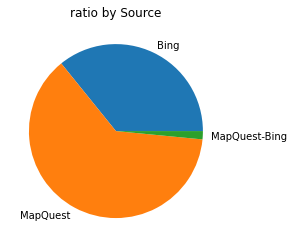

[('Bing', 1516064), ('MapQuest', 2651861), ('MapQuest-Bing', 64616)]


In [104]:
display_piechart_of_column(root_accidents_data, 'Source')

As can be seen above the data comes from 3 sources: MapQuest, Bing, and a mix up of MapQuest-Bing. There are about twice as many inputs from MapQuest compared to Bing

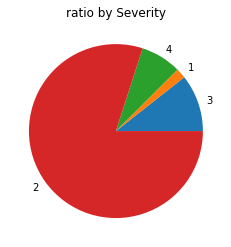

[('3', 161052), ('1', 28178), ('4', 114452), ('2', 1212382)]


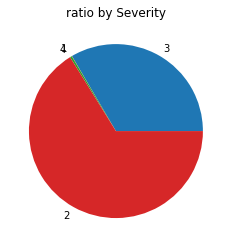

[('3', 886933), ('1', 1115), ('4', 9269), ('2', 1754544)]


In [105]:
bing = root_accidents_data.filter(col('Source') == 'Bing')
display_piechart_of_column(bing, 'Severity')

quest = root_accidents_data.filter(col('Source') == 'MapQuest')
display_piechart_of_column(quest, 'Severity')

as can be seen above, Bing and MapQuest have recorded a different ratios of severities of each level, It looks like Map Quest have stricter requirements for level 4, and such a minority of them was recorded over 5 years. Bing's chart while biased towards severity 2 displays more coverage on other categories. We cannot use both datasets, and while it is hard to choose which one. #todo decide if should choose either or drop

wind analysis

us states analysis. Maybe just do regressions per state to reach better results since authorities mostly care about data within their state and not their neighbour's state


Outlier Treatment

In [106]:
root_accidents_data = root_accidents_data.withColumn('year', sql_func.date_format(root_accidents_data.Start_Time, 'y'))\
    .withColumn('year', col('year').cast(IntegerType()))
root_accidents_data = root_accidents_data.withColumn('month', sql_func.date_format(root_accidents_data.Start_Time, 'M'))\
    .withColumn('month', col('month').cast(IntegerType()))
root_accidents_data = root_accidents_data.withColumn('day', sql_func.date_format(root_accidents_data.Start_Time, 'D'))\
    .withColumn('day', col('day').cast(IntegerType()))
root_accidents_data = root_accidents_data.withColumn('hour_minutes', \
    sql_func.date_format(root_accidents_data.Start_Time, 'H')*60 + sql_func.date_format(root_accidents_data.Start_Time, 'm'))

### Accidents per day of the week

In [107]:
root_accidents_data = root_accidents_data.withColumn('weekday', sql_func.date_format(root_accidents_data.Start_Time, 'E'))

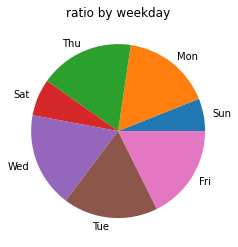

[('Sun', 255920), ('Mon', 703779), ('Thu', 742968), ('Sat', 289754), ('Wed', 747851), ('Tue', 744645), ('Fri', 747624)]


In [108]:
display_piechart_of_column(root_accidents_data, 'weekday')

As we can see on the chart above, accidents are much less frequent on the weekend as they are on the work days, therefore day of the week is an important feature for the classification Model

### Road condition, accident side, street location

#### Side

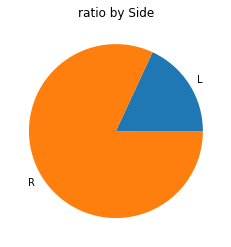

[('L', 765461), ('R', 3467079), (' ', 1)]


In [109]:
display_piechart_of_column(root_accidents_data, 'Side')

should we add bivariate/multivariate analysis?

separate EDA from data pre processing

### Weather Condition and Wind

#### Weather Condition

In [110]:
root_accidents_data.groupBy('Weather_Condition').count().orderBy('count', ascending=False).show(200)

+--------------------+------+
|   Weather_Condition| count|
+--------------------+------+
|                Fair|900872|
|               Clear|808181|
|       Mostly Cloudy|571743|
|       Partly Cloudy|397415|
|            Overcast|382485|
|              Cloudy|323340|
|          Light Rain|206389|
|    Scattered Clouds|204661|
|                null| 98383|
|          Light Snow| 57148|
|                Rain| 48641|
|                Haze| 46794|
|                 Fog| 45912|
|          Heavy Rain| 18223|
|       Light Drizzle| 14594|
|        Fair / Windy| 11396|
|               Smoke|  8327|
|Mostly Cloudy / W...|  6538|
|                Snow|  6430|
|      Cloudy / Windy|  6272|
|             T-Storm|  5019|
|Light Thunderstor...|  4927|
|        Thunderstorm|  4440|
|Thunder in the Vi...|  4332|
|Light Rain with T...|  3981|
|Partly Cloudy / W...|  3881|
|             Thunder|  3510|
|  Light Rain / Windy|  3442|
|      Patches of Fog|  3071|
|             Drizzle|  2946|
|         

Weather conditions are very diverse. We will try to divide them into categories and reassign them

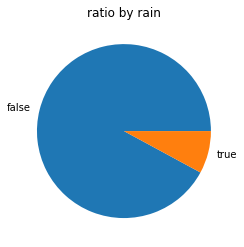

[('false', 3898132), ('true', 334409)]


In [112]:
weather_df = root_accidents_data.withColumn('fair', \
                                         when(col("Weather_Condition").contains('Fair'), lit(True))\
                                        .when(col("Weather_Condition").contains('Clear'), lit(True))\
                                        .when(col("Weather_Condition").contains('Scattered Clouds'), lit(True))\
                                        .when(col("Weather_Condition").contains('Fair / Windy'), lit(True))\
                                        .otherwise(False))

weather_df = weather_df.withColumn('clouds', \
                                         when(col("Weather_Condition").contains('Cloudy'), lit(True))\
                                        .when(col("Weather_Condition").contains('Clouds'), lit(True))\
                                        .when(col("Weather_Condition").contains('Overcast'), lit(True))\
                                        .otherwise(False))
weather_df = weather_df.withColumn('dark_clouds', \
                                         when(col("Weather_Condition").contains('Mostly Cloudy'), lit(True))\
                                        .when(col("Weather_Condition").contains('Overcast'), lit(True))\
                                        .when(col("Weather_Condition").contains('Funnel Cloud'), lit(True))\
                                        .otherwise(False))

weather_df = weather_df.withColumn('fog', \
                                         when(col("Weather_Condition").contains('Haze'), lit(True))\
                                        .when(col("Weather_Condition").contains('Fog'), lit(True))\
                                        .when(col("Weather_Condition").contains('Smoke'), lit(True))\
                                        .when(col("Weather_Condition").contains('Mist'), lit(True))\
                                        .when(col("Weather_Condition").contains('Dust'), lit(True))\
                                        .when(col("Weather_Condition").contains('Sand'), lit(True))\
                                        .when(col("Weather_Condition").contains('Ash'), lit(True))\
                                        .otherwise(False))

weather_df = weather_df.withColumn('rain', \
                                         when(col("Weather_Condition").contains('Drizzle'), lit(True))\
                                        .when(col("Weather_Condition").contains('Rain'), lit(True))\
                                        .when(col("Weather_Condition").contains('Heavy Rain'), lit(True))\
                                        .when(col("Weather_Condition").contains('T-Storm'), lit(True))\
                                        .when(col("Weather_Condition").contains('Thunderstorm'), lit(True))\
                                        .when(col("Weather_Condition").contains('Thunder'), lit(True))\
                                        .when(col("Weather_Condition").contains('Storm'), lit(True))\
                                        .when(col("Weather_Condition").contains('Heavy Drizzle'), lit(True))\
                                        .when(col("Weather_Condition").contains('Tornado'), lit(True))\
                                        .otherwise(False))
weather_df = weather_df.withColumn('heavy_rain', \
                                         when(col("Weather_Condition").contains('Heavy Rain'), lit(True))\
                                        .when(col("Weather_Condition").contains('T-Storm'), lit(True))\
                                        .when(col("Weather_Condition").contains('Thunderstorm'), lit(True))\
                                        .when(col("Weather_Condition").contains('Thunder'), lit(True))\
                                        .when(col("Weather_Condition").contains('Storm'), lit(True))\
                                        .when(col("Weather_Condition").contains('Heavy Drizzle'), lit(True))\
                                        .when(col("Weather_Condition").contains('Tornado'), lit(True))\
                                        .otherwise(False))


weather_df = weather_df.withColumn('snow', \
                                         when(col("Weather_Condition").contains('Snow'), lit(True))\
                                        .when(col("Weather_Condition").contains('Wintry'), lit(True))\
                                        .when(col("Weather_Condition").contains('Ice'), lit(True))\
                                        .when(col("Weather_Condition").contains('Sleet'), lit(True))\
                                        .when(col("Weather_Condition").contains('Hail'), lit(True))\
                                        .when(col("Weather_Condition").contains('Snow Grains'), lit(True))\
                                        .when(col("Weather_Condition").contains('Freezing'), lit(True))\
                                        .otherwise(False))
weather_df = weather_df.withColumn('heavy_snow', \
                                         when(col("Weather_Condition").contains('Freezing'), lit(True))\
                                        .when(col("Weather_Condition").contains('Heavy Snow'), lit(True))\
                                        .when(col("Weather_Condition").contains('Heavy Sleet'), lit(True))\
                                        .when(col("Weather_Condition").contains('Heavy Ice'), lit(True))\
                                        .otherwise(False))
root_accidents_data = weather_df
#windy entries are not considered, given that wind is already well covered in wind_direction and wind_speed
display_piechart_of_column(weather_df, 'rain')

#### Visibility

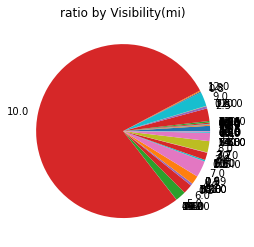

[('1.0', 41191), ('0.75', 6404), ('4.2', 10), ('50.0', 2146), ('75.0', 64), ('22.0', 4), ('90.0', 8), ('20.0', 3318), ('0.31', 1), ('15.0', 3400), ('45.0', 358), ('67.0', 1), ('47.0', 2), ('0.25', 9316), ('0.99', 8), ('0.7', 15), ('4.5', 1), ('63.0', 1), ('25.0', 535), ('0.06', 170), ('6.2', 2), ('120.0', 5), ('0.2', 12092), (None, 98668), ('2.5', 18479), ('72.0', 1), ('110.0', 1), ('1.6', 31), ('0.0', 2642), ('9.0', 111026), ('0.8', 8317), ('1.8', 8400), ('12.0', 366), ('10.0', 3292496), ('0.12', 694), ('3.5', 28), ('14.0', 6), ('46.0', 1), ('1.4', 35), ('19.0', 2), ('70.0', 266), ('111.0', 3), ('5.0', 83104), ('6.0', 73798), ('0.5', 17901), ('0.38', 116), ('101.0', 1), ('34.0', 2), ('35.0', 189), ('100.0', 14), ('58.0', 1), ('4.0', 66937), ('1.9', 44), ('0.9', 48), ('0.19', 8), ('0.6', 72), ('7.0', 128664), ('0.1', 1287), ('105.0', 1), ('1.5', 11325), ('2.8', 129), ('60.0', 195), ('11.0', 148), ('2.0', 57547), ('3.2', 1), ('2.2', 114), ('30.0', 3203), ('3.7', 2), ('8.0', 88559), ('54

In [113]:
display_piechart_of_column(root_accidents_data, 'Visibility(mi)')

In terms of visibility the higher the better. As we can see it is mostly good visibility on the dataset. We do not need such diversity in visibility, so let's round the value to it's nearest integer:

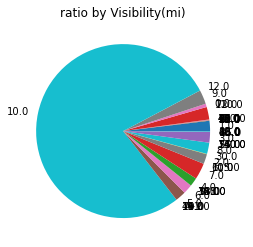

[('1.0', 80693), ('50.0', 2146), ('75.0', 64), ('22.0', 4), ('90.0', 8), ('20.0', 3318), ('15.0', 3400), ('45.0', 358), ('67.0', 1), ('47.0', 2), ('63.0', 1), ('25.0', 535), ('120.0', 5), (None, 98668), ('72.0', 1), ('110.0', 1), ('0.0', 26424), ('9.0', 111026), ('12.0', 366), ('10.0', 3292496), ('14.0', 6), ('46.0', 1), ('19.0', 2), ('70.0', 266), ('111.0', 3), ('5.0', 83105), ('6.0', 73824), ('101.0', 1), ('34.0', 2), ('35.0', 189), ('100.0', 14), ('58.0', 1), ('4.0', 66977), ('7.0', 128664), ('105.0', 1), ('60.0', 195), ('11.0', 174), ('2.0', 77463), ('30.0', 3203), ('8.0', 88559), ('54.0', 1), ('130.0', 1), ('76.0', 3), ('140.0', 2), ('3.0', 83837), ('43.0', 1), ('80.0', 148), ('36.0', 2), ('16.0', 1), ('13.0', 4687), ('40.0', 1691)]


In [114]:
visibility_flattened = root_accidents_data.withColumn('Visibility(mi)', round(root_accidents_data['Visibility(mi)'], 0))
display_piechart_of_column(visibility_flattened, 'Visibility(mi)')

let's also merge all the values where visibility is above 10 miles, as 10 miles is more than enough to avoid an accident, and the extra data would only take expensive computation time. Let's also drop None, since the percentage of None is low enough, not to risk adding noise to the dataset. We could give it a mean visibility value, but risking it is un

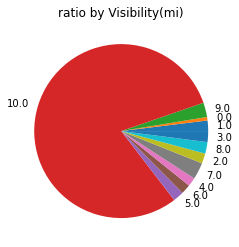

[('1.0', 80693), ('0.0', 26424), ('9.0', 111026), ('10.0', 3313301), ('5.0', 83105), ('6.0', 73824), ('4.0', 66977), ('7.0', 128664), ('2.0', 77463), ('8.0', 88559), ('3.0', 83837)]


In [115]:
root_accidents_data = visibility_flattened\
    .withColumn("Visibility(mi)", when(col("Visibility(mi)") >= 10,lit(10)).otherwise(col("Visibility(mi)")))\
    .where(col("Visibility(mi)").isNotNull())
display_piechart_of_column(root_accidents_data, 'Visibility(mi)')

#### Wind

The below analysis of Wind direction showed that it is very detailed as well as some data is duplicated. For example there are categories 'North' and 'N' that correspond to the same property, 'South' and 'S', 'Variable' and 'VAR' etc. We will fix these as well as we will round up the NNW to just N to simplify computation:
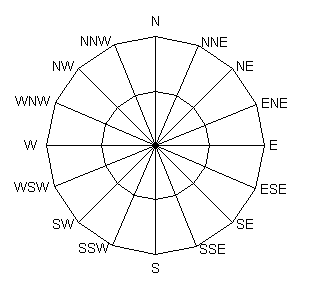

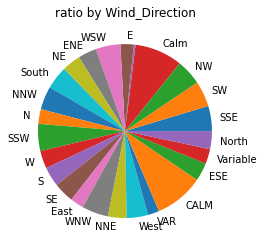

[('SSE', 192710), ('SW', 197079), ('NW', 197028), ('Calm', 366426), (None, 13491), ('E', 101466), ('WSW', 190356), ('ENE', 141812), ('NE', 143879), ('South', 176552), ('NNW', 178262), ('N', 112858), ('SSW', 208352), ('W', 135414), ('S', 150917), ('SE', 156890), ('East', 103061), ('WNW', 203395), ('NNE', 143327), ('West', 163721), ('VAR', 87678), ('CALM', 377664), ('ESE', 140126), ('Variable', 112937), ('North', 138472)]
+--------------+------+
|Wind_Direction| count|
+--------------+------+
|            SW|197079|
|            NW|197028|
|          null| 13491|
|             E|486465|
|            NE|143879|
|             N|572919|
|             W|692886|
|             S|728531|
|            SE|156890|
|          CALM|744090|
|      Variable|200615|
+--------------+------+



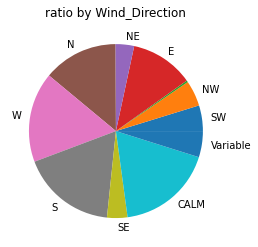

[('SW', 197079), ('NW', 197028), (None, 13491), ('E', 486465), ('NE', 143879), ('N', 572919), ('W', 692886), ('S', 728531), ('SE', 156890), ('CALM', 744090), ('Variable', 200615)]


In [116]:
def correct_column_wind_direction(df):
    df = df.withColumn('Wind_Direction',
                       F.when(df['Wind_Direction'] == 'SSE', 'S')\
                       .when(df['Wind_Direction'] == 'WNW', 'W')
                       .when(df['Wind_Direction'] == 'WSW', 'W')
                       .when(df['Wind_Direction'] == 'NNW', 'N')
                       .when(df['Wind_Direction'] == 'ENE', 'E')
                       .when(df['Wind_Direction'] == 'SSW', 'S')
                       .when(df['Wind_Direction'] == 'South', 'S')
                       .when(df['Wind_Direction'] == 'West', 'W')
                       .when(df['Wind_Direction'] == 'ESE', 'E')
                       .when(df['Wind_Direction'] == 'East', 'E')
                       .when(df['Wind_Direction'] == 'North', 'N')
                       .when(df['Wind_Direction'] == 'NNE', 'N')
                       .when(df['Wind_Direction'] == 'VAR', 'Variable')
                       .when(df['Wind_Direction'] == 'Calm', 'CALM')
                       .otherwise(df['Wind_Direction']))
    return df

display_piechart_of_column(root_accidents_data, 'Wind_Direction')
wind_df = correct_column_wind_direction(root_accidents_data)
wind_df.groupBy('Wind_Direction').count().show()
display_piechart_of_column(wind_df, 'Wind_Direction')
root_accidents_data = wind_df

let's round up the wind speed now, replace null values with mean of wind in the column and group all values more than 150 into 150 group:

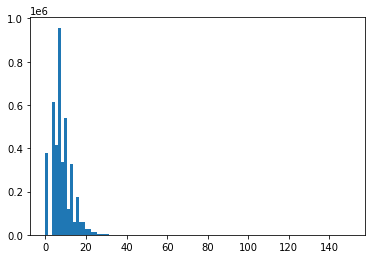

In [117]:
mean = root_accidents_data.select(_mean(col('Wind_Speed(mph)')).alias('mean')).collect()[0]['mean']
wind_flattened = root_accidents_data\
    .withColumn('Wind_Speed(mph)', when(col('Wind_Speed(mph)').isNull(), mean)\
                .when(col('Wind_Speed(mph)') > 150, 150)\
                .otherwise(col('Wind_Speed(mph)')))
wind_flattened = wind_flattened.withColumn('Wind_Speed(mph)', col('Wind_Speed(mph)').cast(IntegerType()))
wind_values = np.array(wind_flattened.select('Wind_Speed(mph)').collect())

plt.hist(wind_values, bins=100)
plt.show()

we can see that the data is highly right skewed, potentially more noramlization will be needed, as well as a more sophisticated encoder for wind speed

### POI

drop description since POI are accessible via other columns

### Address analysis

#### Street type

Here we will change the street data, which consists the names of the street where the accident occured to the type of the street. For example I-5 N, I-95 N, San Diego Fwy S will all be assigned a street_type 'highway', whereas 109th Ln, 10th Ave E, 110th St will be assigned a 'regular' stret_type

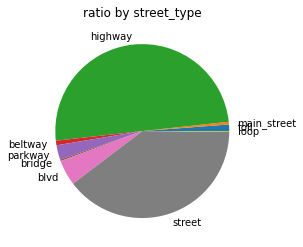

[('toll', 50224), ('main_street', 20706), ('highway', 2069053), ('beltway', 35289), ('parkway', 111483), ('bridge', 11552), ('blvd', 196184), ('street', 1632481), ('loop', 6901)]


In [118]:
street_types = root_accidents_data.withColumn('street_type', \
                                         when(col("Street").contains('I-'), lit('highway'))\
                                         .when(col("Street").contains('US-'), lit('highway'))\
                                         .when(col("Street").contains('CA-'), lit('highway'))\
                                         .when(col("Street").contains('FL-'), lit('highway'))\
                                         .when(col("Street").contains('GA-'), lit('highway'))\
                                         .when(col("Street").contains('CT-'), lit('highway'))\
                                         .when(col("Street").contains('MN-'), lit('highway'))\
                                         .when(col("Street").contains('AZ-'), lit('highway'))\
                                         .when(col("Street").contains('Fwy'), lit('highway'))\
                                         .when(col("Street").contains('Connector'), lit('highway'))\
                                         .when(col("Street").contains('-'), lit('highway'))\
                                         .when(col("Street").contains('Expy'), lit('highway'))\
                                         .when(col("Street").contains('Express'), lit('highway'))\
                                         .when(col("Street").contains('Way'), lit('highway'))\
                                         .when(col("Street").contains('Hwy'), lit('highway'))\
                                         .when(col("Street").contains('Interstate'), lit('highway'))\
                                         .when(col("Street").contains('Highway'), lit('highway'))\
                                         .when(col("Street").contains('Freeway'), lit('highway'))\
                                         .when(col("Street").contains('Pike'), lit('highway'))\
                                         .when(col("Street").contains('Route'), lit('highway'))\
                                         .when(col("Street").contains('Belt'), lit('beltway'))\
                                         .when(col("Street").contains('belt'), lit('beltway'))\
                                         .when(col("Street").contains('Cir'), lit('beltway'))\
                                         .when(col("Street").contains('Tpke'), lit('toll'))\
                                         .when(col("Street").contains('Trwy'), lit('toll'))\
                                         .when(col("Street").contains('Tollway'), lit('toll'))\
                                         .when(col("Street").contains('Pkwy'), lit('parkway'))\
                                         .when(col("Street").contains('Park'), lit('parkway'))\
                                         .when(col("Street").contains('Main St'), lit('main_street'))\
                                         .when(col("Street").contains('Ave'), lit('street'))\
                                         .when(col("Street").contains('St'), lit('street'))\
                                         .when(col("Street").contains('Rd'), lit('street'))\
                                         .when(col("Street").contains('Road'), lit('street'))\
                                         .when(col("Street").contains('Ln'), lit('street'))\
                                         .when(col("Street").contains('Dr'), lit('street'))\
                                         .when(col("Street").contains('Trl'), lit('street'))\
                                         .when(col("Street").contains('Trail'), lit('street'))\
                                         .when(col("Street").contains('Camino'), lit('street'))\
                                         .when(col("Street").contains('Path'), lit('street'))\
                                         .when(col("Street").contains('Blvd'), lit('blvd'))\
                                         .when(col("Street").contains('Boulevard'), lit('blvd'))\
                                         .when(col("Street").contains('Broadway'), lit('blvd'))\
                                         .when(col("Street").contains('Brg'), lit('bridge'))\
                                         .when(col("Street").contains('Tun'), lit('bridge'))\
                                         .when(col("Street").contains('Bridge'), lit('bridge'))\
                                         .when(col("Street").contains('way'), lit('highway'))\
                                         .when(col("Street").contains('Loop'), lit('loop'))\
                                         .when(col("Street").contains('Pl'), lit('street'))\
                                         .when(col("Street").contains('Plaza'), lit('street'))\
                                         .when(col("Street").contains('wy'), lit('highway'))\
                                         .when(col("Street").contains('W '), lit('highway'))\
                                         .when(col("Street").contains('S '), lit('highway'))\
                                         .when(col("Street").contains('N '), lit('highway'))\
                                         .when(col("Street").contains('E '), lit('highway'))\
                                         .when(col("Street").contains('Byp'), lit('highway'))\
                                         .when(col("Street").contains('FM '), lit('highway'))\
                                         .when(col("Street").contains('Ct'), lit('street'))\
                                        .otherwise('street'))
display_piechart_of_column(street_types, 'street_type')
root_accidents_data = street_types

as can be seen the mojority of the traffic happens on the highways, it would be great to see the comparison by severity by street type

### States analysis

In [119]:
def build_states_graph(df):
    data = df.groupBy("State").count().filter(col('State') != 'null').collect()
    states = [row['State'] for row in data]
    state_counts = [row['count'] for row in data]

    fig = go.Figure(
        data=go.Choropleth(
            locations = states,
            z = state_counts,
            locationmode = 'USA-states',
            colorscale = 'SunsetDark',
            colorbar_title = "Count"),
        layout=go.Layout(
            title_text='US Accidents by State (Feb 2016—Dec 2020)',
            title_x=0.5,
            font=dict(family='Verdana', size=12, color='#000000'),
            geo_scope='usa'))

    fig.show()
    
build_states_graph(root_accidents_data)

Roads often get blocked for maintanance, there are a lot of unkown external factors besides all the given information. People in US states are also very different in their cultural values, mindsets. The problem of traffic is the most prevalent in California, as can be seen above so to make estimates more precise we will also filter by California State

In [120]:
relevant_dataset = root_accidents_data.filter(col('State') == 'CA').filter((col('year') == 2019) | ((col('year') == 2020)))
relevant_dataset.count()

508919

There is a clear dataset imbalance problem we have to deal with

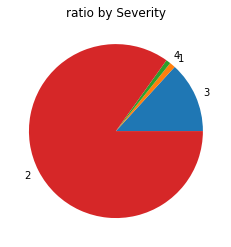

[('3', 67189), ('1', 5476), ('4', 4358), ('2', 431896)]


In [121]:
display_piechart_of_column(relevant_dataset, 'Severity')

'Severity' is largely dominated by class '2'. To solve this, we will oversample the minority classes and undersample majority.

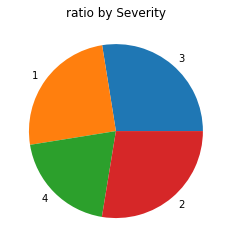

[('3', 60328), ('1', 54760), ('4', 43580), ('2', 60424)]


In [122]:
def upsample_df(df, sample_num):
    a = range(sample_num)
    return df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
sev_1 = upsample_df(relevant_dataset.filter(col('Severity') == 1), 10)
sev_2 = relevant_dataset.filter(col('Severity') == 2).sample(0.14, seed)
sev_3 = relevant_dataset.filter(col('Severity') == 3).sample(0.9, seed)
sev_4 = upsample_df(relevant_dataset.filter(col('Severity') == 4), 10)
balanced_dataset = sev_1.unionAll(sev_2).unionAll(sev_3).unionAll(sev_4)
#balanced_dataset = balanced_dataset.sampleBy('Severity', {1: 1.0, 2: 0.3, 3: 1.0, 4: 1.0}, seed=seed)
display_piechart_of_column(balanced_dataset, 'Severity')


Now the Severity class is much more balanced

In [123]:
'''
#predicting 2 classes only:
two_classes = root_accidents_data.withColumn('Severity', when(col('Severity') == 4, lit(1)).otherwise(lit(0)))
display_piechart_of_column(two_classes.sampleBy('Severity', {0: 0.03, 1: 1.0}, seed), 'Severity')
balanced_dataset = two_classes'''

"\n#predicting 2 classes only:\ntwo_classes = root_accidents_data.withColumn('Severity', when(col('Severity') == 4, lit(1)).otherwise(lit(0)))\ndisplay_piechart_of_column(two_classes.sampleBy('Severity', {0: 0.03, 1: 1.0}, seed), 'Severity')\nbalanced_dataset = two_classes"

# Modeling

In [124]:
def test_model(estimator, is_classification, dataframe, categorical_features, continuous_features, label_to_predict, seed):
    #only select specified columns for featurization
    dataframe = dataframe.select(label_to_predict, *categorical_features, *continuous_features).dropna()
    #featurize columns, convert categorical into vectors
    label_features_df = df_to_label_features(dataframe, label_to_predict, categorical_features, continuous_features)
    (training, test) = label_features_df.randomSplit([0.8, 0.2], seed)

    #train and fit
    model = estimator.fit(training)
    predictions_labels = model.transform(test)
    predictions_labels.show()

    #evaluate
    print_metrics(predictions_labels, is_classification)

#helper functions for regression/classification
def df_to_label_features(dataframe, label_to_predict, categorical_features, continuous_features):
    # stages = build_pipeline_stages(categorical_features, continuous_features)
    # pipelined_dataframe = pipeline_dataframe(stages, dataframe)
    hasher = FeatureHasher(inputCols=[*categorical_features, *continuous_features], outputCol='features')
    featurized = hasher.transform(dataframe)
    label_features = featurized.select(label_to_predict, 'features').withColumnRenamed(label_to_predict, 'label')
    return label_features



def print_metrics(predictions, is_classification):
    evaluator = None
    if is_classification:
        evaluator = MulticlassClassificationEvaluator()
        metrics = ['accuracy', 'f1']
    else:
        evaluator = RegressionEvaluator()
        metrics = ['rmse']
    for metric in metrics:
        evaluation = evaluator.evaluate(predictions, {evaluator.metricName: metric})
        print(f'{metric}: {evaluation}')
        

In [ ]:
test_model(LogisticRegression(maxIter=10), True, balanced_dataset, \
           ['street_type', 'Wind_Direction', 'Sunrise_Sunset', 'fair', 'clouds', 'dark_clouds', 'fog', 'rain', 'heavy_rain', 'snow', 'heavy_snow', 'weekday', 'Side',\
            'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit','Railway', 'Roundabout','Station','Stop', 'Traffic_Signal', 'Traffic_Calming'], \
           ['Wind_Speed(mph)', 'Start_Lat', 'Start_Lng', 'Visibility(mi)', 'hour_minutes', 'year', 'day'], 'Severity', seed)

# Results